In [1]:
%matplotlib inline
from google.cloud import storage
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
import numpy as np
from pathlib import Path
import tensorflow as tf
import os
from PIL import Image
from IPython.display import HTML

In [2]:
# Define bucket and blob prefix

label_bucket_name = 'catflap-photo-labels'
model_bucket_name = 'cat-detection-models'
photo_bucket_name = 'catflap-photos-raw'
dates = ['2020-06-07','2020-06-08']

In [3]:
# Set up buckets

client = storage.Client()
label_bucket = client.get_bucket(label_bucket_name)
model_bucket = client.get_bucket(model_bucket_name)
photo_bucket = client.get_bucket(photo_bucket_name)

# Construct ground truth data set from labels

In [4]:
# Get list of blob names

#blobs = label_bucket.list_blobs(prefix=f'cat_detection_labels - {date}')
#blob_list = [blob.name for blob in blobs]
#blob_list

In [5]:
blob_list = [f'cat_detection_labels - {date}.csv' for date in dates]
blob_list

['cat_detection_labels - 2020-06-07.csv',
 'cat_detection_labels - 2020-06-08.csv']

In [6]:
# Read labels into pandas dataframe

df_list = []
for blob in blob_list:
    labels = pd.read_csv('gs://'+label_bucket_name+'/'+blob)
    df_list += [labels]
label_df = pd.concat(df_list, ignore_index=True, sort=False)

print(label_df.shape)
label_df.head()

(8821, 6)


,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat
0,gs://catflap-photos-raw/2020-06-07_080031.jpg,False,NaN,NaN,NaN,NaN
1,gs://catflap-photos-raw/2020-06-07_080039.jpg,False,NaN,NaN,NaN,NaN
2,gs://catflap-photos-raw/2020-06-07_080046.jpg,False,NaN,NaN,NaN,NaN
3,gs://catflap-photos-raw/2020-06-07_080053.jpg,False,NaN,NaN,NaN,NaN
4,gs://catflap-photos-raw/2020-06-07_080100.jpg,False,NaN,NaN,NaN,NaN


In [7]:
# Convert contains cat from boolean to integer

label_df['contains_cat_int'] = label_df.contains_cat.astype('int32')
label_df.head()

,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat,contains_cat_int
0,gs://catflap-photos-raw/2020-06-07_080031.jpg,False,NaN,NaN,NaN,NaN,0
1,gs://catflap-photos-raw/2020-06-07_080039.jpg,False,NaN,NaN,NaN,NaN,0
2,gs://catflap-photos-raw/2020-06-07_080046.jpg,False,NaN,NaN,NaN,NaN,0
3,gs://catflap-photos-raw/2020-06-07_080053.jpg,False,NaN,NaN,NaN,NaN,0
4,gs://catflap-photos-raw/2020-06-07_080100.jpg,False,NaN,NaN,NaN,NaN,0


In [8]:
# Extract filename from blob location

label_df['filename'] = label_df.blob_location.str.split('/').apply(lambda x: x[-1])

label_df.head()

,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat,contains_cat_int,filename
0,gs://catflap-photos-raw/2020-06-07_080031.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080031.jpg
1,gs://catflap-photos-raw/2020-06-07_080039.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080039.jpg
2,gs://catflap-photos-raw/2020-06-07_080046.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080046.jpg
3,gs://catflap-photos-raw/2020-06-07_080053.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080053.jpg
4,gs://catflap-photos-raw/2020-06-07_080100.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080100.jpg


# Read predictions produced by batch prediction

In [9]:
# Get list of blob names

blob_list = []
for date in dates:
    blobs = model_bucket.list_blobs(prefix=f'batch-output-keys/{date}/prediction.results')
    blob_date_list = [blob.name for blob in blobs]
    blob_list += blob_date_list
blob_list

['batch-output-keys/2020-06-07/prediction.results-00000-of-00003',
 'batch-output-keys/2020-06-07/prediction.results-00001-of-00003',
 'batch-output-keys/2020-06-07/prediction.results-00002-of-00003',
 'batch-output-keys/2020-06-08/prediction.results-00000-of-00006',
 'batch-output-keys/2020-06-08/prediction.results-00001-of-00006',
 'batch-output-keys/2020-06-08/prediction.results-00002-of-00006',
 'batch-output-keys/2020-06-08/prediction.results-00003-of-00006',
 'batch-output-keys/2020-06-08/prediction.results-00004-of-00006',
 'batch-output-keys/2020-06-08/prediction.results-00005-of-00006']

In [10]:
# Read predictions into pandas dataframe

df_list = []
for blob in blob_list:
    labels = pd.read_json('gs://'+model_bucket_name+'/'+blob, lines=True)
    df_list += [labels]
prediction_df = pd.concat(df_list, ignore_index=True, sort=False)

print(prediction_df.shape)
prediction_df.head()

(8821, 2)


,babyweight,key
0,"[337.5148010253906, 3.351402759552002]",2020-06-07_100119.jpg
1,"[339.47869873046875, 2.841537952423095]",2020-06-07_100126.jpg
2,"[335.00054931640625, 7.376816272735596]",2020-06-07_100133.jpg
3,"[335.5783386230469, 3.46913194656372]",2020-06-07_100140.jpg
4,"[332.3962707519531, 7.271667957305908]",2020-06-07_100147.jpg


In [11]:
# Extract prediction

prediction_df['prediction'] = prediction_df.babyweight.apply(np.argmax)

prediction_df.head()

,babyweight,key,prediction
0,"[337.5148010253906, 3.351402759552002]",2020-06-07_100119.jpg,0
1,"[339.47869873046875, 2.841537952423095]",2020-06-07_100126.jpg,0
2,"[335.00054931640625, 7.376816272735596]",2020-06-07_100133.jpg,0
3,"[335.5783386230469, 3.46913194656372]",2020-06-07_100140.jpg,0
4,"[332.3962707519531, 7.271667957305908]",2020-06-07_100147.jpg,0


In [12]:
prediction_df.prediction.value_counts()

0    8573
1     248
Name: prediction, dtype: int64

# Join ground truth against prediction

In [13]:
# Join on index

merge_df = label_df.merge(prediction_df, left_on='filename', right_on='key')

print(merge_df.shape)
merge_df.head()

(8821, 11)


,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat,contains_cat_int,filename,babyweight,key,prediction
0,gs://catflap-photos-raw/2020-06-07_080031.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080031.jpg,"[228.51795959472656, -14.532011985778809]",2020-06-07_080031.jpg,0
1,gs://catflap-photos-raw/2020-06-07_080039.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080039.jpg,"[233.7031707763672, -17.070945739746094]",2020-06-07_080039.jpg,0
2,gs://catflap-photos-raw/2020-06-07_080046.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080046.jpg,"[231.4474639892578, -25.645584106445312]",2020-06-07_080046.jpg,0
3,gs://catflap-photos-raw/2020-06-07_080053.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080053.jpg,"[233.3055419921875, -16.91278839111328]",2020-06-07_080053.jpg,0
4,gs://catflap-photos-raw/2020-06-07_080100.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080100.jpg,"[243.53501892089844, -24.511451721191406]",2020-06-07_080100.jpg,0


# Analyse predictions

In [14]:
# Remove photos where Thomas is outside or barely in shot
# We don't mind what prediction is made for these photos

# Get positive examples

eval_df = merge_df.copy()
eval_df = eval_df[(eval_df.in_or_out == 'in') | (eval_df.contains_cat==False)]
eval_df = eval_df[(eval_df.proportion_of_cat>.8) | (eval_df.contains_cat==False)]

print(eval_df.shape)
eval_df.head()

(8517, 11)


,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat,contains_cat_int,filename,babyweight,key,prediction
0,gs://catflap-photos-raw/2020-06-07_080031.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080031.jpg,"[228.51795959472656, -14.532011985778809]",2020-06-07_080031.jpg,0
1,gs://catflap-photos-raw/2020-06-07_080039.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080039.jpg,"[233.7031707763672, -17.070945739746094]",2020-06-07_080039.jpg,0
2,gs://catflap-photos-raw/2020-06-07_080046.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080046.jpg,"[231.4474639892578, -25.645584106445312]",2020-06-07_080046.jpg,0
3,gs://catflap-photos-raw/2020-06-07_080053.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080053.jpg,"[233.3055419921875, -16.91278839111328]",2020-06-07_080053.jpg,0
4,gs://catflap-photos-raw/2020-06-07_080100.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080100.jpg,"[243.53501892089844, -24.511451721191406]",2020-06-07_080100.jpg,0


In [15]:
# Calculate confusion matrix

eval_df.groupby(['contains_cat_int','prediction']).blob_location.count().unstack()

prediction,0,1
contains_cat_int,,
0,8310,199
1,2,6


In [16]:
# Create columns for each cell in confusion matrix

eval_df.loc[:,'tp'] = (eval_df.contains_cat_int==1) & (eval_df.prediction==1)
eval_df.loc[:,'fp'] = (eval_df.contains_cat_int==0) & (eval_df.prediction==1)
eval_df.loc[:,'fn'] = (eval_df.contains_cat_int==1) & (eval_df.prediction==0)
eval_df.loc[:,'tn'] = (eval_df.contains_cat_int==0) & (eval_df.prediction==0)

eval_df.head()

,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat,contains_cat_int,filename,babyweight,key,prediction,tp,fp,fn,tn
0,gs://catflap-photos-raw/2020-06-07_080031.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080031.jpg,"[228.51795959472656, -14.532011985778809]",2020-06-07_080031.jpg,0,False,False,False,True
1,gs://catflap-photos-raw/2020-06-07_080039.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080039.jpg,"[233.7031707763672, -17.070945739746094]",2020-06-07_080039.jpg,0,False,False,False,True
2,gs://catflap-photos-raw/2020-06-07_080046.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080046.jpg,"[231.4474639892578, -25.645584106445312]",2020-06-07_080046.jpg,0,False,False,False,True
3,gs://catflap-photos-raw/2020-06-07_080053.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080053.jpg,"[233.3055419921875, -16.91278839111328]",2020-06-07_080053.jpg,0,False,False,False,True
4,gs://catflap-photos-raw/2020-06-07_080100.jpg,False,NaN,NaN,NaN,NaN,0,2020-06-07_080100.jpg,"[243.53501892089844, -24.511451721191406]",2020-06-07_080100.jpg,0,False,False,False,True


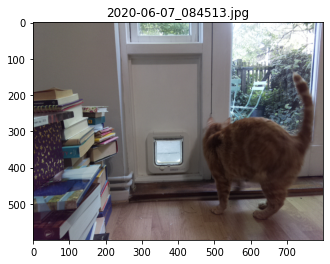

In [17]:
# Plot true positives

for blob_name in eval_df[eval_df.tp].filename:
    
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    plt.figure()
    plt.imshow(img)
    plt.title(blob_name)
    
    break

In [18]:
# Create GIF of true positives

train_images = []
for blob_name in eval_df[eval_df.tp].filename:
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = Image.open(bytes_io)
    img_resize = img.resize((80*4,60*4))
    train_images += [img_resize]
gif_filename = 'true_positives.gif'
train_images[0].save(gif_filename, save_all=True, append_images=train_images[1:], optimize=True, duration=100, loop=0, dpi=(80,60))

#HTML(f'<img src="{gif_filename}">')

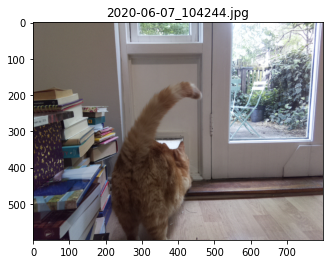

In [19]:
# Plot false negatives

for blob_name in eval_df[eval_df.fn].filename:
    
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    plt.figure()
    plt.imshow(img)
    plt.title(blob_name)
    
    break

In [20]:
# Create GIF of false negatives

train_images = []
for blob_name in eval_df[eval_df.fn].filename:
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = Image.open(bytes_io)
    img_resize = img.resize((80*4,60*4))
    train_images += [img_resize]
gif_filename = 'false_negatives.gif'
train_images[0].save(gif_filename, save_all=True, append_images=train_images[1:], optimize=True, duration=100, loop=0, dpi=(80,60))

#HTML(f'<img src="{gif_filename}">')

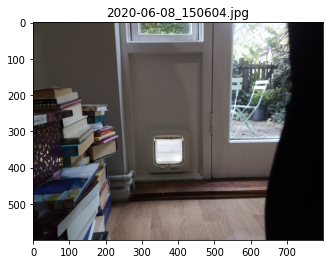

In [21]:
# Plot false positives

for blob_name in eval_df[eval_df.fp].filename.iloc[:10]:
    
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    plt.figure()
    plt.imshow(img)
    plt.title(blob_name)
    
    break

In [22]:
# Create GIF of false positives

train_images = []
for blob_name in eval_df[eval_df.fp].filename:
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = Image.open(bytes_io)
    img_resize = img.resize((80*4,60*4))
    train_images += [img_resize]
gif_filename = 'false_positives.gif'
train_images[0].save(gif_filename, save_all=True, append_images=train_images[1:], optimize=True, duration=100, loop=0, dpi=(80,60))

#HTML(f'<img src="{gif_filename}">')